# Regresión Logística con Python

Para esta sesión, estaremos trabajando con el [Conjunto de datos Titanic de Kaggle](https://www.kaggle.com/c/titanic). Este es un conjunto de datos muy famoso y a menudo se utiliza para introducir a estudiantes al Aprendizaje de Máquina (Machine Learning)! 

Trataremos de predecir una clasificación - supervivencia o fallecimiento.
Iniciemos nuestra comprensión la de la implementación de la Regresión Logística con Python para clasificar.

Utilizaremos una versión "semi-limpia" del conjunto de datos Titanic.  NOTA:  Si decide utilizar el conjunto de datos directamente de Kaggle, puede que necesite hacer más limpieza de la que estaremos haciendo acá.


## Importar Librerías

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Los datos

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Análisis Exploratorio de Datos (EDA)

Empezaremos con el chequeo por datos faltantes!

## Datos faltantes

Hemos visto varias formas de hacerlo, para algo diferente, utilizaremos **Seaborn** para crear un mapa de calor que nos muestre dónde hacen falta datos!

<AxesSubplot:>

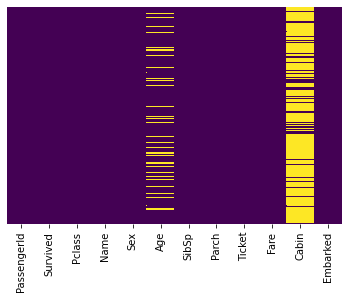

In [6]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Aproximadamente el 20% de los datos de **Edad** hacen falta.  Esta proporción probablemente es lo suficientemente pequeño como para llenar valores con alguna forma de imputación.  Si vemos la columna **Cabin**, parece que simplemente hay demasiados datos faltantes como para hacer algo útil, al menos a un nivel básico.  Lo más probable es que botaremos esta columna, o cambiamos el significado a algo como "Cabina conocida:  1 o 0".

Continuemos con más visualizaciones.

<AxesSubplot:xlabel='Survived', ylabel='count'>

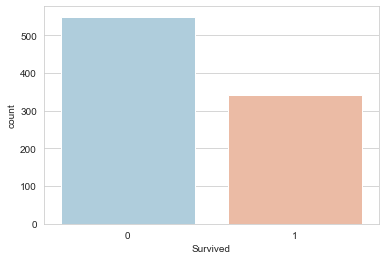

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

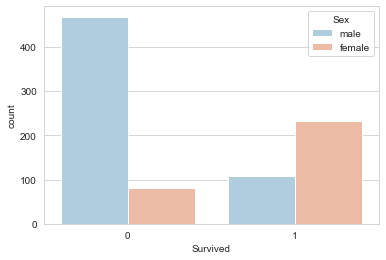

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

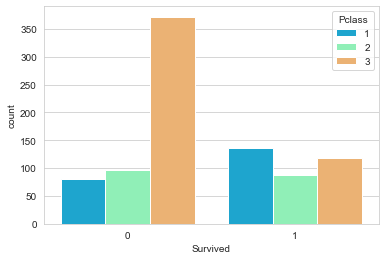

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

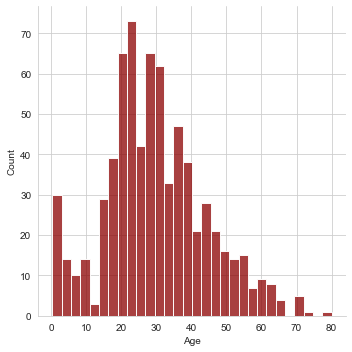

In [10]:
sns.displot(train['Age'].dropna(),color='darkred',bins=30)

<AxesSubplot:>

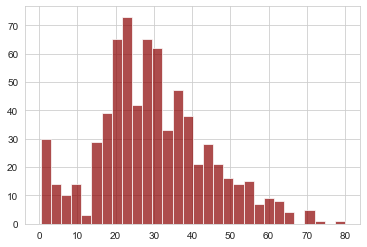

In [11]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

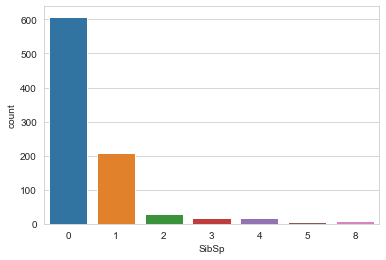

In [12]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

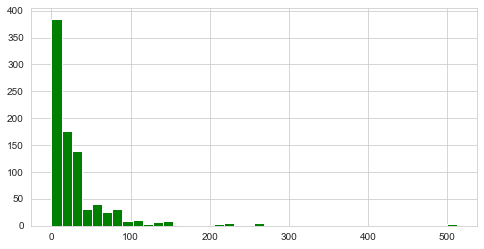

In [13]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

____
### Cufflinks para gráficas
___
 Tomemos un momento breve para ve algo de **Cufflinks**!

In [15]:
! pip install cufflinks

     |████████████████████████████████| 81 kB 739 kB/s eta 0:00:01
  Using cached jedi-0.18.0-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.8.2-py2.py3-none-any.whl (94 kB)


  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67922 sha256=d9ee368ccbceaee11ef7372b33f586167f25ef154fcb15c3b32e0b975bea6ed9
  Stored in directory: /Users/rudiks/Library/Caches/pip/wheels/e1/27/13/3fe67fa7ea7be444b831d117220b3b586b872c9acd4df480d0
Successfully built cufflinks
  Attempting uninstall: parso
    Found existing installation: parso 0.5.2
    Uninstalling parso-0.5.2:
      Successfully uninstalled parso-0.5.2
  Attempting uninstall: jedi
    Found existing installation: jedi 0.14.1
    Uninstalling jedi-0.14.1:
      Successfully uninstalled jedi-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
spyder 4.0.1 requires jedi==0.14.1, but you have je

In [16]:
import cufflinks as cf
cf.go_offline()

In [17]:
train['Fare'].iplot(kind='hist',bins=30,color='green')

___
## Limpieza de datos

Deseamos dar valores a los datos faltante de edad, en vez de solo eliminar las filas que no tengan ese valor.  Una forma de hacerlo es usando la edad promedio de todos los pasajeros (imputación)

Sin embargo, vamos a ser un poco más inteligentes y usaremos la edad promedio por Clase en la que viajan los pasajeros.  Por ejemplo:


In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Podemos ver que los pasajeros más "pudientes" en las clases más altas, tienden a ser mayores, que hace mucho sentido.

Utilizaremos estos valores promedio de edad basados en **Pclass** para la edad.

In [ ]:
def imputar_edad(cols):
    edad = cols[0]
    clase = cols[1]
    
    if pd.isnull(edad):

        if clase == 1:
            return 37

        elif clase == 2:
            return 29

        else:
            return 24

    else:
        return edad

Ahora apliquemos esa función!

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(imputar_edad,axis=1)

Veamos el mapa de calor de nuevo!

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Fabuloso! Eliminemos la columna **Cabin** y la fila en **Embarked** que tiene un NaN.

In [ ]:
train.drop('Cabin',axis=1,inplace=True)

In [ ]:
train.head()

In [ ]:
train.dropna(inplace=True)

## Convertir Columnas Categóricas

Será necesario convertir las columnas categóricas a variables "dummy" o comodines utilizando Pandas!  De no hacerlo, nuestro algortimo de Machine Learning no podrá tomar esas columnas como entradas ya que necesita que sean numéricas.



In [ ]:
train.info()

In [ ]:
sexo = pd.get_dummies(train['Sex'],drop_first=True)
embarque = pd.get_dummies(train['Embarked'],drop_first=True)

In [ ]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [ ]:
train = pd.concat([train,sexo,embarque],axis=1)

In [ ]:
train.head()

Ahora sí, nuestros datos están listos para modelar!

# Preparar un modelo de Regresión Logística

Iniciemos con dividir nuestros datos en un cojunto para entrenar (training) y otro para probar (test)...hay otro archivo **test.csv** con el que puede hacer pruebas si acaso desea usar todo el conjunto inicial para entrenar.

## Partir en Train / Test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Entrenamiento y Predicción

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logmodel = LogisticRegression(max_iter = 500)
logmodel.fit(X_train,y_train)

In [ ]:
predictions = logmodel.predict(X_test)

Pasémos a evaluar el modelo!

## Evaluación

Podemos chequear: precision, recall y f1-score utilizando **classificationn report**!

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,predictions))

No está mal!  Puede que desee explorar otras formas de organizar los datos (feature engineering) y el otro archivo **titanic_text-csv**, algunas sugerencias de trabajar los datos:

* Intente extraer el título (Dr., Mr., Mrs, etc.) de el nombre, y dejarlo como otra columna
* Quizás la letra de la Cabina podría ser una variable importante
* ¿Hay alguna información de el **Ticket** que podría ser útil?